# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [143]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
# import pandas as pd
# import hvplot.pandas
# import sqlalchemy as sq


In [144]:
pn.extension('plotly')


In [145]:
import hvplot.pandas

In [146]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [147]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [148]:
def housing_units_per_year():
    """Housing Units Per Year."""
    sfo_yearly_housing = sfo_data['housing_units'].groupby(['year']).mean()
    sfo_yearly = sfo_data.groupby(['year']).mean()
    min = sfo_yearly_housing.min()
    max = sfo_yearly_housing.max()
    std = sfo_yearly_housing.std()
    housing_units_fig = plt.figure()
    sfo_yearly_barchart = sfo_yearly_housing.plot.bar(ylim = (min - std, max + std))
    sfo_yearly_barchart.set_title('Housing units in San-Francisco 2010-2016', fontsize=14, fontweight='bold')
    sfo_yearly_barchart.set_ylabel('Housing Units')
    plt.close(housing_units_fig)
    return pn.pane.Matplotlib(housing_units_fig, tight=True)


In [149]:
def average_gross_rent():  
    """Average Gross Rent in San Francisco Per Year."""
    sfo_yearly = sfo_data.groupby(['year']).mean()
    avg_rent = sfo_yearly['gross_rent']
    avg_rent_fig = plt.figure()
    avg_rent_plot = avg_rent.plot()
    avg_rent_plot.set_title('Average Gross Rent in San-Francisco 2010-2016', fontsize=14, fontweight='bold')
    avg_rent_plot.set_ylabel('Rent')
    plt.close(avg_rent_fig)
    return pn.pane.Matplotlib(avg_rent_fig, tight=True)


In [150]:
def average_sales_price():
    """Average Sales Price Per Year."""
    sfo_yearly_housing = sfo_data['housing_units'].groupby(['year']).mean()
    sfo_yearly = sfo_data.groupby(['year']).mean()
    avg_rent = sfo_yearly['gross_rent']
    avg_sqfoot = sfo_yearly['sale_price_sqr_foot']
    average_sales_price_fig = plt.figure()
    average_sales_price = avg_sqfoot.plot.line()
    average_sales_price.set_title('Average Sales Price per Year', fontsize=14, fontweight='bold')
    average_sales_price.set_ylabel('gross_rent')
    plt.close(average_sales_price_fig)
    return pn.pane.Matplotlib(average_sales_price_fig, tight=True)


In [151]:
def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    sfo_neighbohood_yearly = sfo_data.groupby(['year', 'neighborhood']).mean()
    sfo_neighbohood_yearly.reset_index(inplace=True)
    sfo_neighbohood_yearly_plot = sfo_neighbohood_yearly.hvplot.line( x='year', y='sale_price_sqr_foot', groupby='neighborhood')
    return sfo_neighbohood_yearly_plot


In [152]:
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    expensive_neighborhoods = sfo_data.groupby('neighborhood').mean()
    expensive_neighborhoods.sort_values(by = 'sale_price_sqr_foot', ascending=False, inplace=True)
    expensive_neighborhoods.reset_index(inplace=True)
    expensive_neighborhood = expensive_neighborhoods.head(10)
    expensive_neighborhood_plot = expensive_neighborhood.hvplot.bar(x='neighborhood', y='sale_price_sqr_foot',rot=90)
    return expensive_neighborhood_plot


In [153]:
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    expensive_neighborhoods = sfo_data.groupby('neighborhood').mean()
    expensive_neighborhoods.sort_values(by = 'sale_price_sqr_foot', ascending=False, inplace=True)
    expensive_neighborhoods.reset_index(inplace=True)
    expensive_neighborhood = expensive_neighborhoods.head(10)
#     expensive_neighborhood_plot = expensive_neighborhood.hvplot.line(x='neighborhood', y='sale_price_sqr_foot',rot=90)
    parallel_coordinates = px.parallel_coordinates(expensive_neighborhood, color="sale_price_sqr_foot", color_continuous_scale = px.colors.sequential.Inferno)

    return parallel_coordinates


In [154]:
def parallel_categories():
    """Parallel Categories Plot."""
    expensive_neighborhoods = sfo_data.groupby('neighborhood').mean()
    expensive_neighborhoods.sort_values(by = 'sale_price_sqr_foot', ascending=False, inplace=True)
    expensive_neighborhoods.reset_index(inplace=True)
    expensive_neighborhood = expensive_neighborhoods.head(10)
    expensive_neighborhood.hvplot.line(x='neighborhood', y='sale_price_sqr_foot',rot=90)
    parallel_categories = px.parallel_categories(expensive_neighborhood.round(3), dimensions=['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent'], color="sale_price_sqr_foot", color_continuous_scale = px.colors.sequential.Inferno)

    return parallel_categories


In [155]:
   
file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)
df_neighborhood_locations.rename(columns = {'Neighborhood':'neighborhood'}, inplace=True)
mean_values = sfo_data.groupby('neighborhood').mean()
mean_values.reset_index(inplace=True)
neighborhood_location = pd.merge(df_neighborhood_locations,mean_values, on='neighborhood')
neighborhood_location

,neighborhood,Lat,Lon,sale_price_sqr_foot,housing_units,gross_rent
0,Alamo Square,37.791012,-122.402100,366.020712,378401.00,2817.285714
1,Anza Vista,37.779598,-122.443451,373.382198,379050.00,3031.833333
2,Bayview,37.734670,-122.401060,204.588623,376454.00,2318.400000
3,Bayview Heights,37.728740,-122.410980,590.792839,382295.00,3739.000000
4,Buena Vista Park,37.768160,-122.439330,452.680591,378076.50,2698.833333
...,...,...,...,...,...,...
64,West Portal,37.740260,-122.463880,498.488485,376940.75,2515.500000
65,Western Addition,37.792980,-122.435790,307.562201,377427.50,2555.166667
66,Westwood Highlands,37.734700,-122.456854,533.703935,376454.00,2250.500000
67,Westwood Park,37.734150,-122.457000,687.087575,382295.00,3959.000000


In [156]:
def neighborhood_map():
    """Neighborhood Map"""
    
    file_path = Path("Data/neighborhoods_coordinates.csv")
    df_neighborhood_locations = pd.read_csv(file_path)
    df_neighborhood_locations.rename(columns = {'Neighborhood':'neighborhood'}, inplace=True)
    mean_values = sfo_data.groupby('neighborhood').mean()
    mean_values.reset_index(inplace=True)
    neighborhood_location = pd.merge(df_neighborhood_locations,mean_values, on='neighborhood')
    neighborhood_location_plot = px.scatter_mapbox(
        neighborhood_location, 
        lat='Lat', 
        lon='Lon', 
        color='gross_rent', 
        size='sale_price_sqr_foot', 
        title='Averange Sale Price Per Square Foot and Gross Rent in San Francisco',
        color_continuous_scale=px.colors.cyclical.IceFire, 
        size_max=15, 
        zoom=10)
    
    map_panel = pn.pane.Plotly(neighborhood_location_plot)
    map_panel._updates = True 
    return map_panel

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [157]:
housing_units_column = pn.Column(
    '## Housing Units Sold per Year',
    housing_units_per_year()
)

Column
    [0] Markdown(str)
    [1] Matplotlib(Figure, tight=True)
    [2] Matplotlib(Figure, tight=True)
    [3] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
            [1] VSpacer()
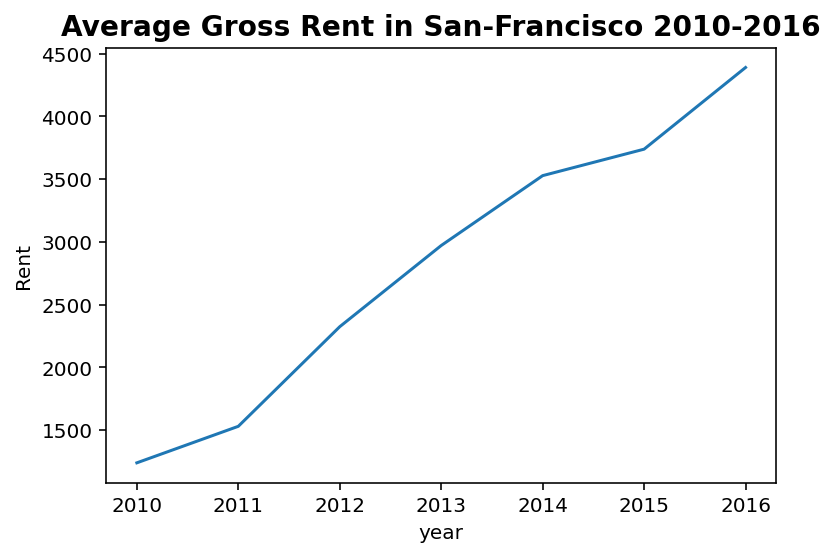
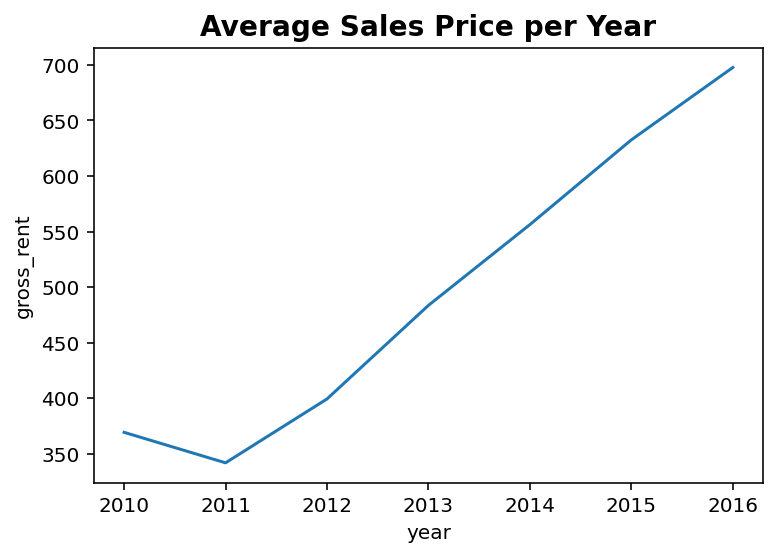

In [158]:
averages_column = pn.Column(
    'Avg. Gross Rent, Sales Price, and Price by Neighborhood',
    average_gross_rent(),
    average_sales_price(),
    average_price_by_neighborhood()
)
averages_column

In [159]:
top_ten_column = pn.Column(
    'Top Ten Most Expensive Neighborhoods',
    top_most_expensive_neighborhoods(),
)
top_ten_column

Column
    [0] Markdown(str)
    [1] HoloViews(Bars)

In [160]:
parallel_column = pn.Column(
    '## Parallel Coordinates and Categories',
    parallel_coordinates(),
    parallel_categories(),
)
parallel_column

Column
    [0] Markdown(str)
    [1] Plotly(Figure)
    [2] Plotly(Figure)

In [161]:
map_column = pn.Column(
    '## Average Values per Neighborhood Maps',
    neighborhood_map()
)
map_column

Column
    [0] Markdown(str)
    [1] Plotly(Figure)

In [162]:
# Create tabs
sfo_dashboard = pn.Tabs(
    ('Housing Units Sold', housing_units_column),
    ('Averages', averages_column),
    ('Most Expensive', top_ten_column),
    ('Parallel Graphs', parallel_column),
    ('Map', map_column)
)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Matplotlib(Figure, tight=True)
        [1] Column
            [0] Markdown(str)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
            [3] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
        [2] Column
            [0] Markdown(str)
            [1] HoloViews(Bars)
        [3] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
            [2] Plotly(Figure)
        [4] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
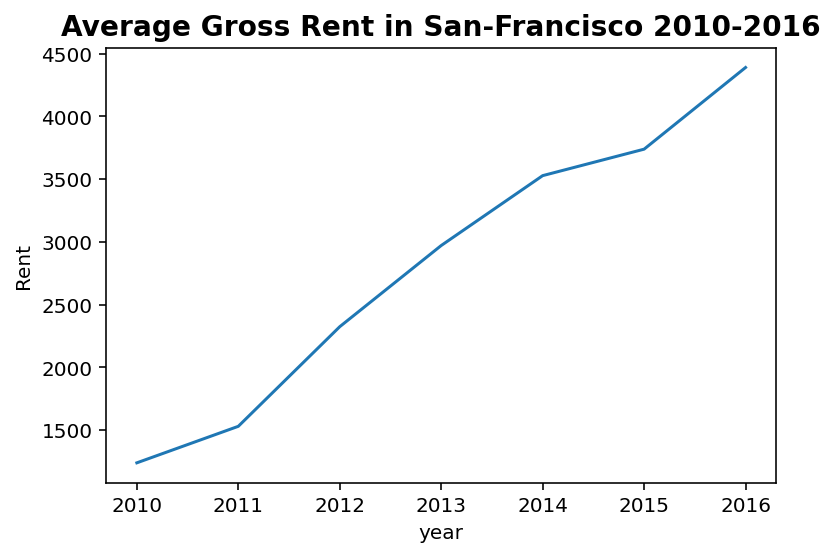
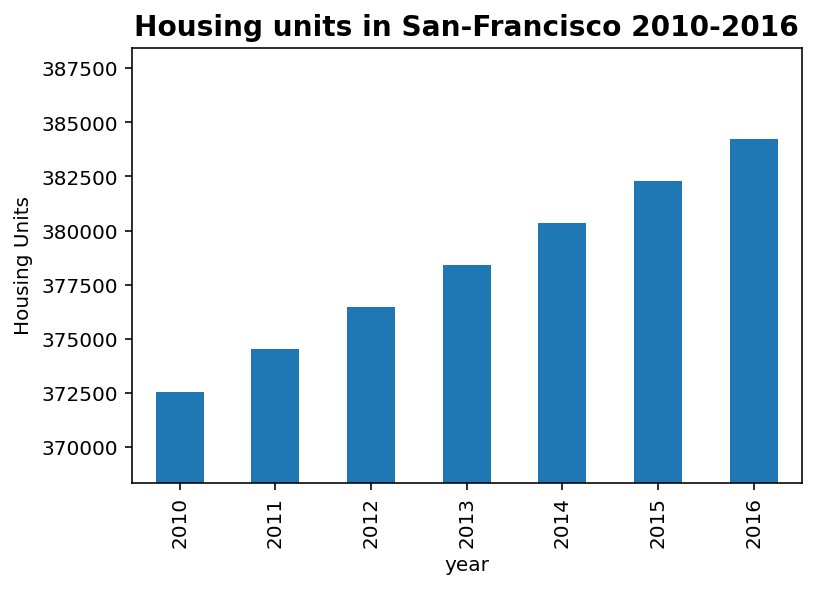
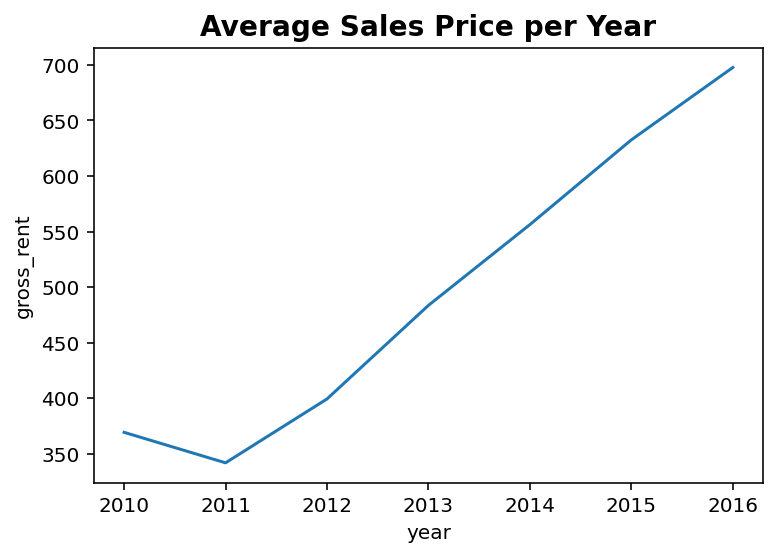

In [163]:
panel = pn.Column(f'# Real Estate Analysis of San Francisco from {sfo_data.index.min()} to {sfo_data.index.max()}<br/>',
                  sfo_dashboard
                 )
panel

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Matplotlib(Figure, tight=True)
    [1] Column
        [0] Markdown(str)
        [1] Matplotlib(Figure, tight=True)
        [2] Matplotlib(Figure, tight=True)
        [3] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [4] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
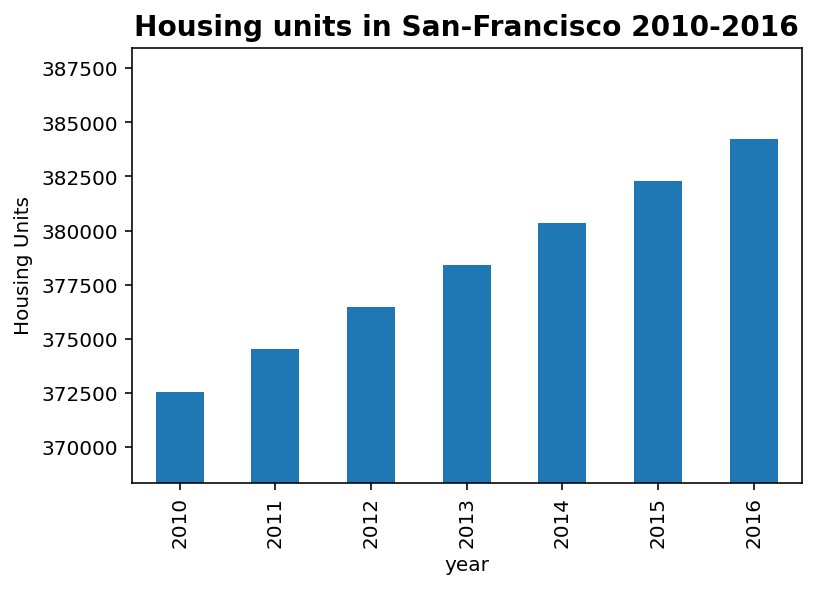
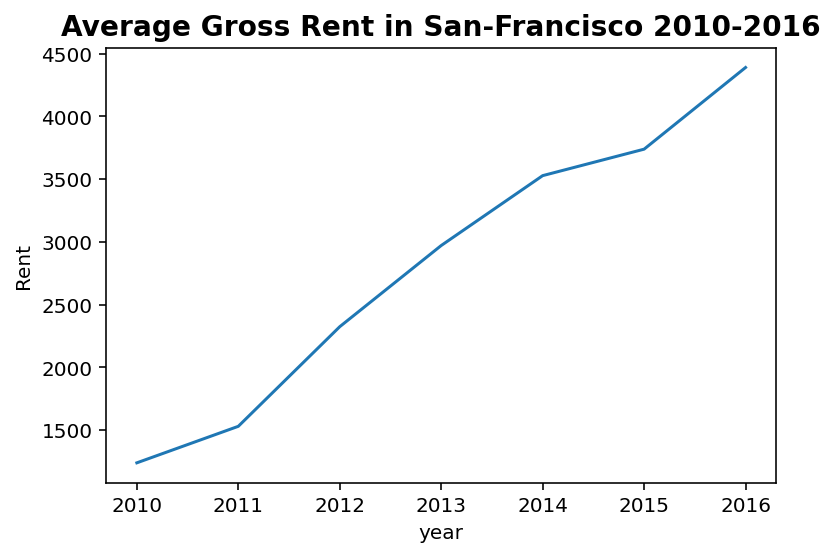
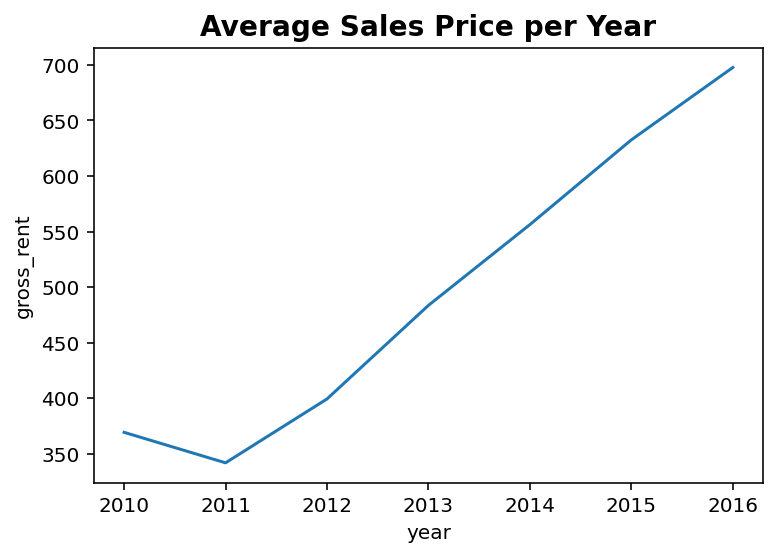

In [164]:
sfo_dashboard.servable()